# 1. Data Preparing

In [22]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.metrics import mean_squared_error

In [9]:
data = pd.read_excel("Monthly Inflation Rate.xlsx",index_col='Time', parse_dates=['Time'])
df=pd.DataFrame(data)
df.head()

,Inflation Rate
Time,
1999年1月,-2.42
1999年2月,-2.83
1999年3月,-3.24
1999年4月,-2.98
1999年5月,-3.06


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 1999年1月 to 2023年9月
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Inflation Rate  297 non-null    float64
dtypes: float64(1)
memory usage: 4.6+ KB


In [14]:
# No NAN value

In [11]:
df.describe()

,Inflation Rate
count,297.000000
mean,2.329394
std,3.207226
min,-3.650000
25%,-0.200000
50%,2.550000
75%,5.070000
max,9.490000


## 1.1 Check the Stationarity

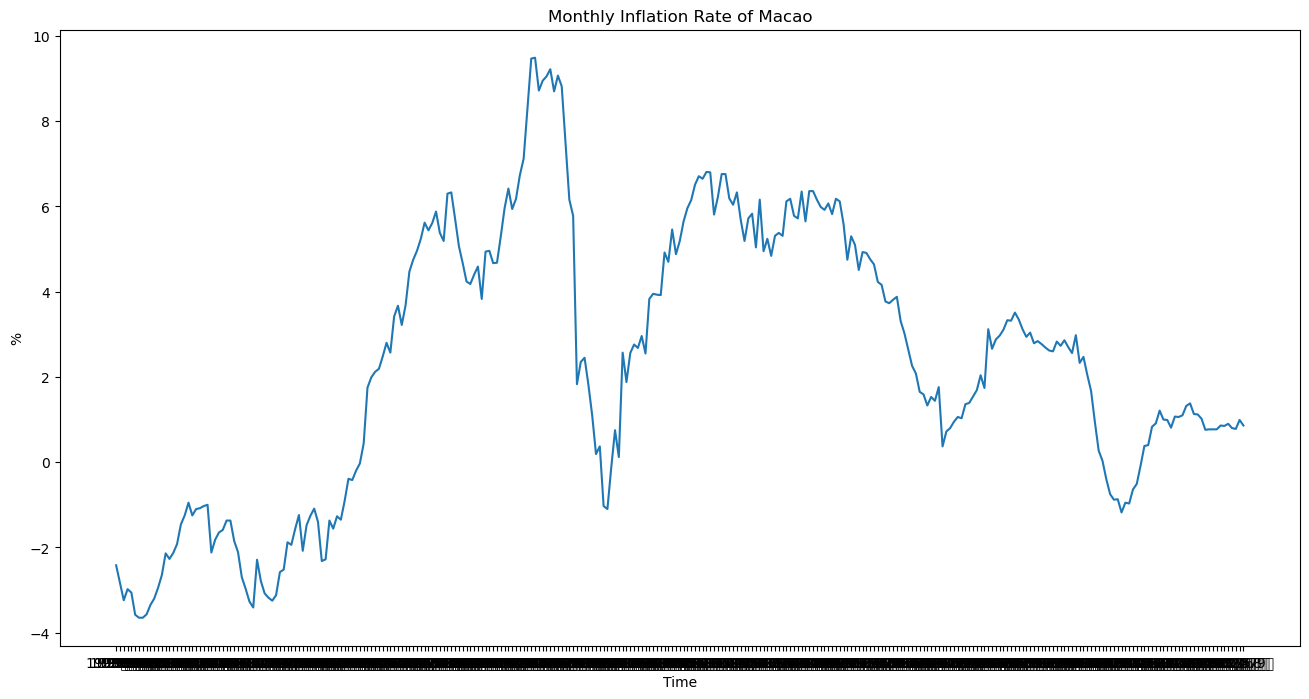

In [17]:
plt.figure(figsize=(16,8))
plt.title('Monthly Inflation Rate of Macao')
plt.xlabel('Time')
plt.ylabel('%')
plt.plot(df);

In [18]:
# Apparently not stationary. A slightly increasing trend.

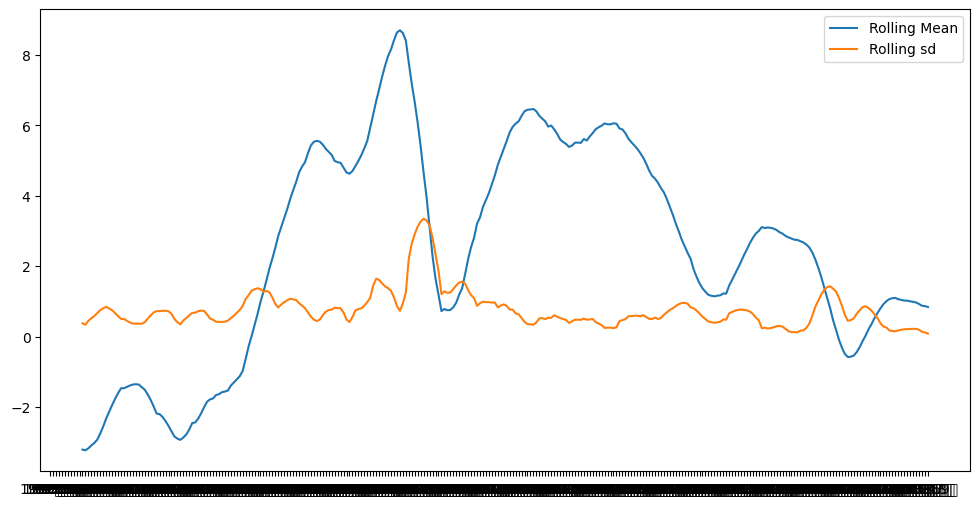

In [19]:
# Check Stationarity

plt.figure(figsize=(12,6))
plt.plot(df.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(df.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [20]:
# The mean is not constant, therefore the time series is not stationary.

# We also can run ADF test to test the stationarity

In [67]:
from statsmodels.tsa.stattools import adfuller

adftest0 = adfuller(df)
adf_results0= pd.Series(adftest0[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
    adf_results0['Critical Value (%s)'%key] = value
adf_results0

Test Statistic                  -1.807183
p-value                          0.376902
#Lags Used                      12.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64

In [29]:
# Therefore, as p-value>0.05 and test statistic is larger than Critical Value (5%), so fail to reject the null hypothesis i.e. the time seires is non-stationary

## 1.2 Transform to a stationary time series

In [30]:
# Remove the trend by first order differencing 

df_diff = df.diff().dropna()

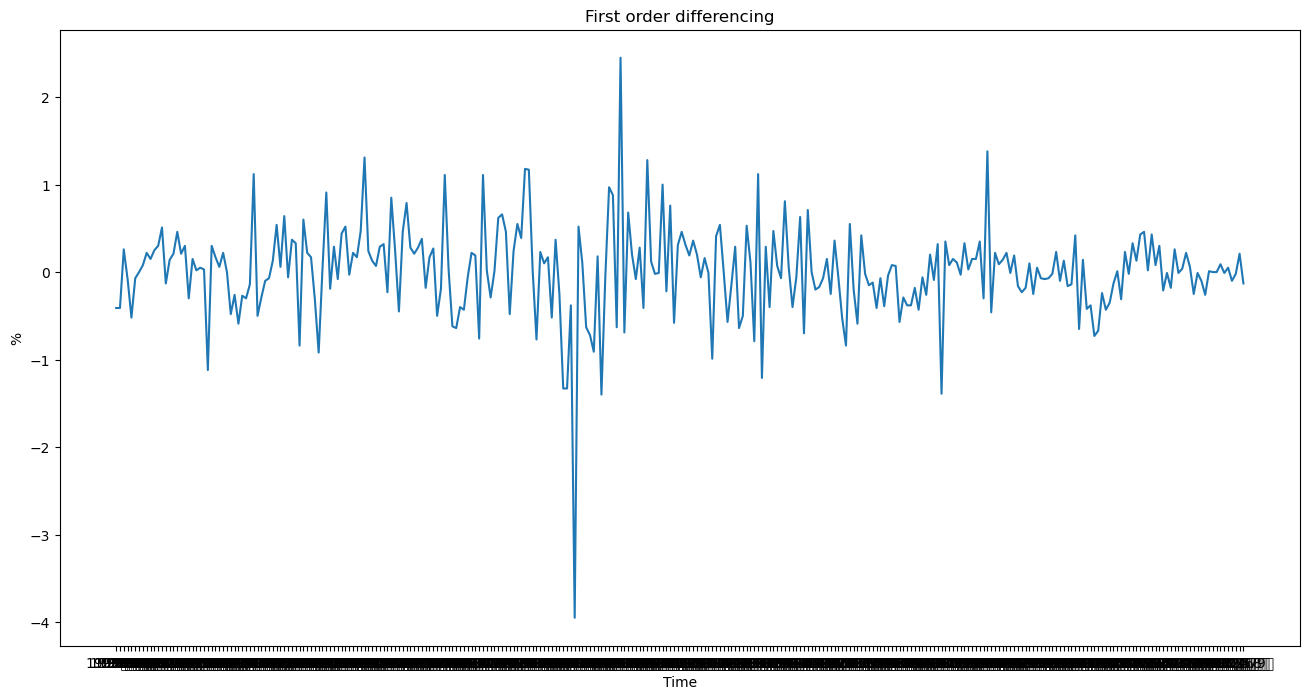

In [31]:
plt.figure(figsize=(16,8))
plt.title('First order differencing')
plt.xlabel('Time')
plt.ylabel('%')
plt.plot(df_diff);

In [66]:
# Apply ADF test again

adftest = adfuller(df_diff)
adf_results= pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
    adf_results['Critical Value (%s)'%key] = value
adf_results

Test Statistic                -7.027643e+00
p-value                        6.303815e-10
#Lags Used                     1.100000e+01
Number of Observations Used    2.840000e+02
Critical Value (1%)           -3.453587e+00
Critical Value (5%)           -2.871771e+00
Critical Value (10%)          -2.572222e+00
dtype: float64

In [38]:
# Therefore, as p-value<0.05 and the test statistic is less than Critical Value (5%), so reject the null hypothesis i.e. the first order differenced time seires is stationary

## 1.4 Decomposition

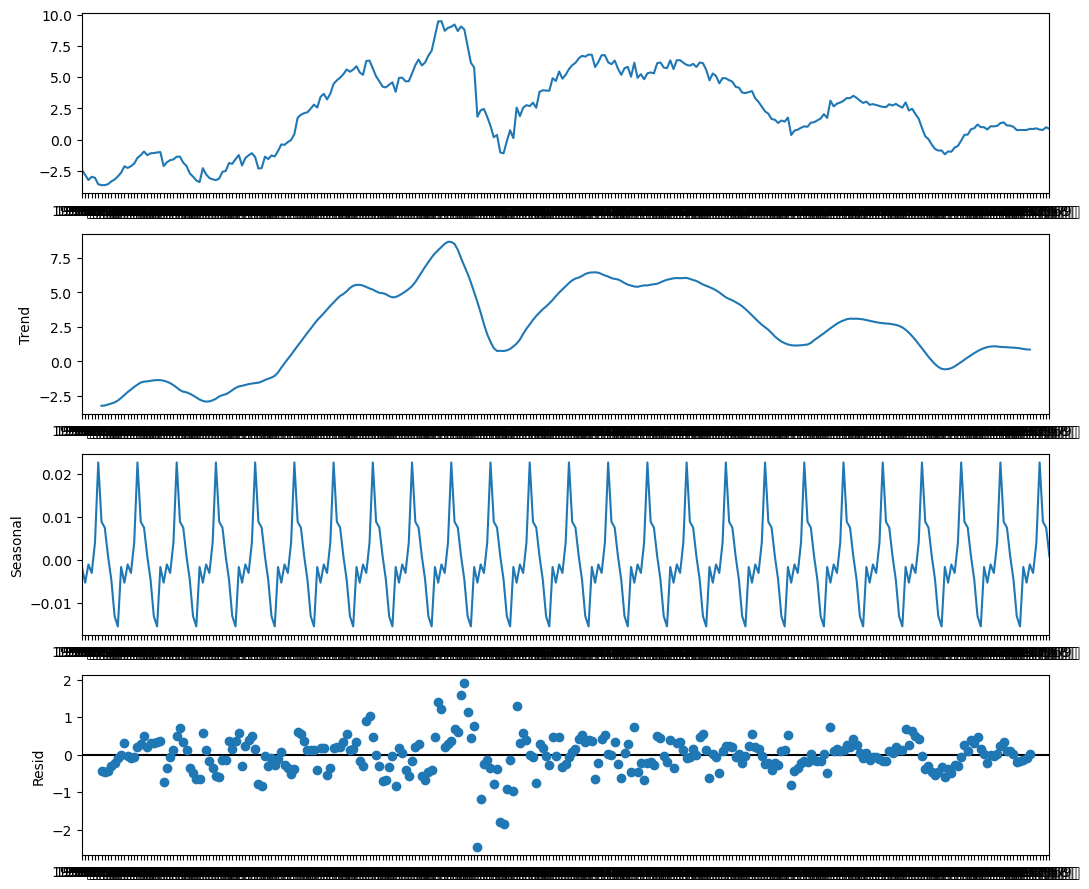

In [37]:
# Decomposition: Check the trend, seasonality and residuals at once

from pylab import rcParams

rcParams['figure.figsize'] = 11, 9
decomposed = sm.tsa.seasonal_decompose(df,period=12) 
figure = decomposed.plot() #This line is creating a plot of the decomposed time series. The plot will have four subplots: the original time series, the trend component, the seasonal component, and the residual component.
plt.show()

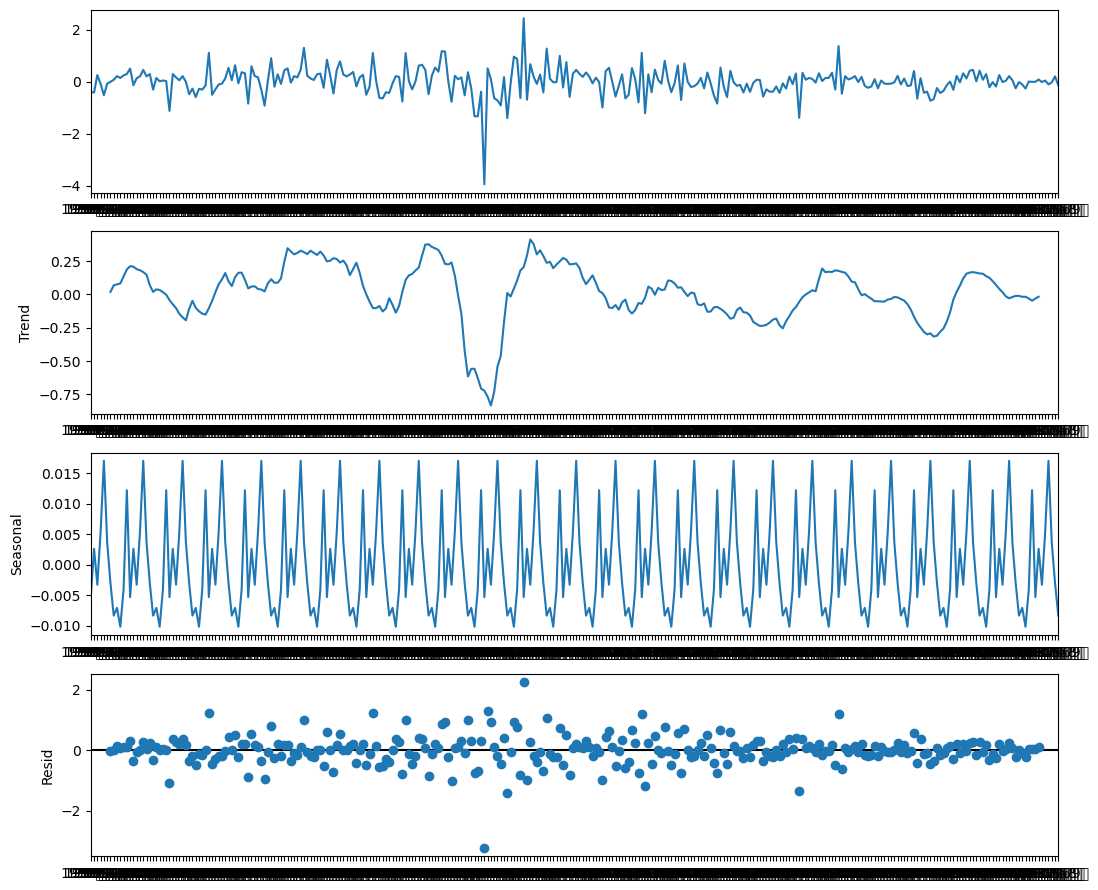

In [40]:
# Decompose the differenced df

rcParams['figure.figsize'] = 11, 9
diff_decomposed = sm.tsa.seasonal_decompose(df_diff,period=12) 
figure = diff_decomposed.plot() #This line is creating a plot of the decomposed time series. The plot will have four subplots: the original time series, the trend component, the seasonal component, and the residual component.
plt.show()

## 1.3 Split training and testing sets

In [104]:
split_point = int(len(df) * 0.8)

train = df.iloc[:split_point]
test = df.iloc[split_point:]

In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237 entries, 1999年1月 to 2018年9月
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Inflation Rate  237 non-null    float64
dtypes: float64(1)
memory usage: 3.7+ KB


In [106]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 2018年10月 to 2023年9月
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Inflation Rate  60 non-null     float64
dtypes: float64(1)
memory usage: 960.0+ bytes


# 2. Select the appropriate model

## Plot ACF and PACF

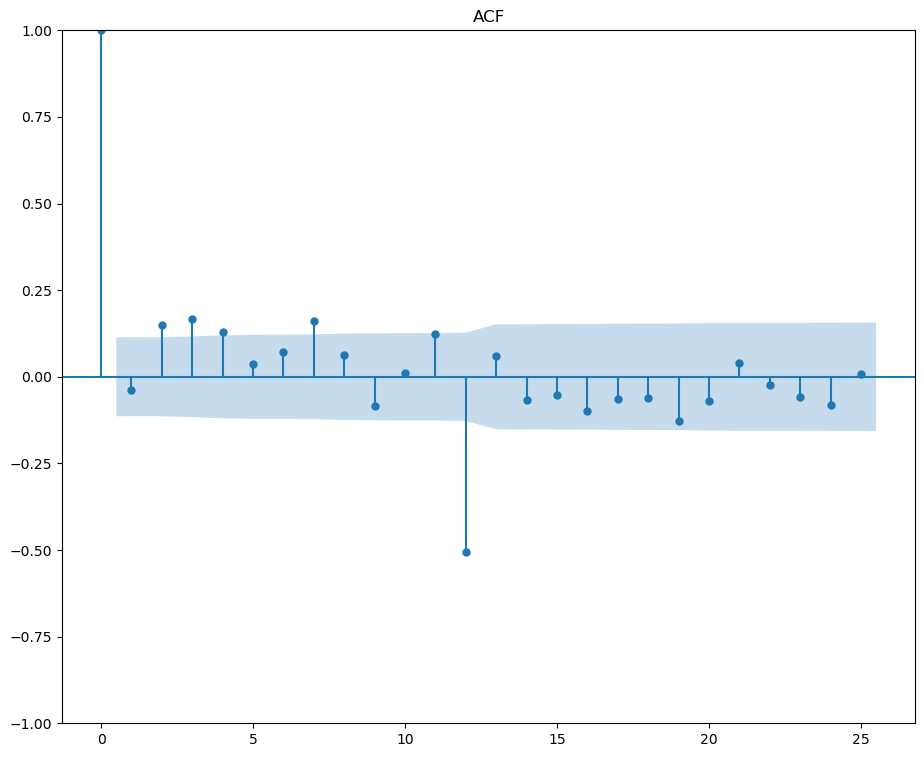

In [107]:
plot_acf(df_diff,lags=25,title="ACF")
plt.show()

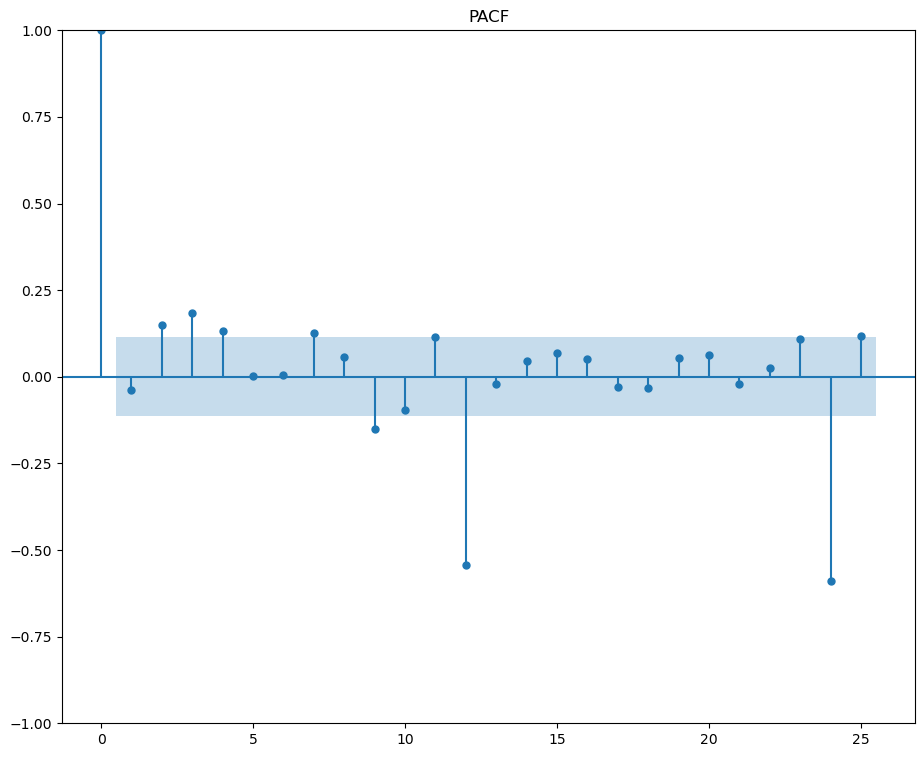

In [108]:
plot_pacf(df_diff,lags=25,title="PACF")
plt.show()

In [109]:
# ACF and PACF plots suggest a SARMA model

## Try ARMA

In [110]:
# Create empty list to store search results
order_aic_bic=[]

for p in range(0, 3):
 
    for q in range(0, 3):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(df_diff, order=(p,0,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, q, results.aic, results.bic))

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84286D-01    |proj g|=  3.55826D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     16      1     0     0   3.557D-05   7.843D-01
  F =  0.78428631686332240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.8

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83580D-01    |proj g|=  2.60161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   4.138D-05   7.836D-01
  F =  0.78357948902330976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.1

 This problem is unconstrained.



At iterate   10    f=  7.47916D-01    |proj g|=  5.78308D-03

At iterate   15    f=  7.47907D-01    |proj g|=  3.75922D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   3.759D-08   7.479D-01
  F =  0.74790721624119227     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72426D-01    |proj g|=  4.91215D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.71588D-01    |proj g|=  1.69808D-02

At iterate   10    f=  7.61325D-01    |proj g|=  8.09802D-02

At iterate   15    f=  7.52254D-01    |proj g|=  6.79184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   1.468D-06   7.522D-01
  F =  0.75222724264320628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53378D-01    |proj g|=  3.19718D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  7.43008D-01    |proj g|=  3.65419D-02

At iterate   20    f=  7.21397D-01    |proj g|=  4.02086D-02

At iterate   25    f=  7.05482D-01    |proj g|=  4.17157D-02

At iterate   30    f=  7.02779D-01    |proj g|=  1.17139D-02

At iterate   35    f=  7.02177D-01    |proj g|=  2.76379D-03

At iterate   40    f=  7.02108D-01    |proj g|=  1.99918D-03

At iterate   45    f=  7.02094D-01    |proj g|=  5.12090D-04

At iterate   50    f=  7.02093D-01    |proj g|=  1.56190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   1.562D-04   7.021D-01
  F =  0.702092669410

In [111]:
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values(by='AIC', ascending=True))

# Print order_df in order of increasing BIC
print(order_df.sort_values(by='BIC', ascending=True))

   p  q         AIC         BIC
8  2  2  425.638860  444.090658
5  1  2  450.761072  465.522510
7  2  1  453.318528  468.079965
2  0  2  462.967948  474.039026
6  2  0  463.273363  474.344442
4  1  1  463.714903  474.785981
0  0  0  466.297500  469.987859
3  1  0  467.879058  475.259776
1  0  1  467.977703  475.358422
   p  q         AIC         BIC
8  2  2  425.638860  444.090658
5  1  2  450.761072  465.522510
7  2  1  453.318528  468.079965
0  0  0  466.297500  469.987859
2  0  2  462.967948  474.039026
6  2  0  463.273363  474.344442
4  1  1  463.714903  474.785981
3  1  0  467.879058  475.259776
1  0  1  467.977703  475.358422


In [112]:
model = sm.tsa.ARIMA(train,order=(2,1,2))
arma = model.fit()
print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:         Inflation Rate   No. Observations:                  237
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -186.500
Date:                Tue, 21 Nov 2023   AIC                            383.000
Time:                        22:22:38   BIC                            400.319
Sample:                             0   HQIC                           389.981
                                - 237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5397      0.062     25.032      0.000       1.419       1.660
ar.L2         -0.6967      0.066    -10.506      0.000      -0.827      -0.567
ma.L1         -1.7376      0.036    -47.860      0.0

In [113]:
# As the p-value for Ljung-Box test is 0.98>0.05，so we can reject the null hypothesis that there is autocorrelation.

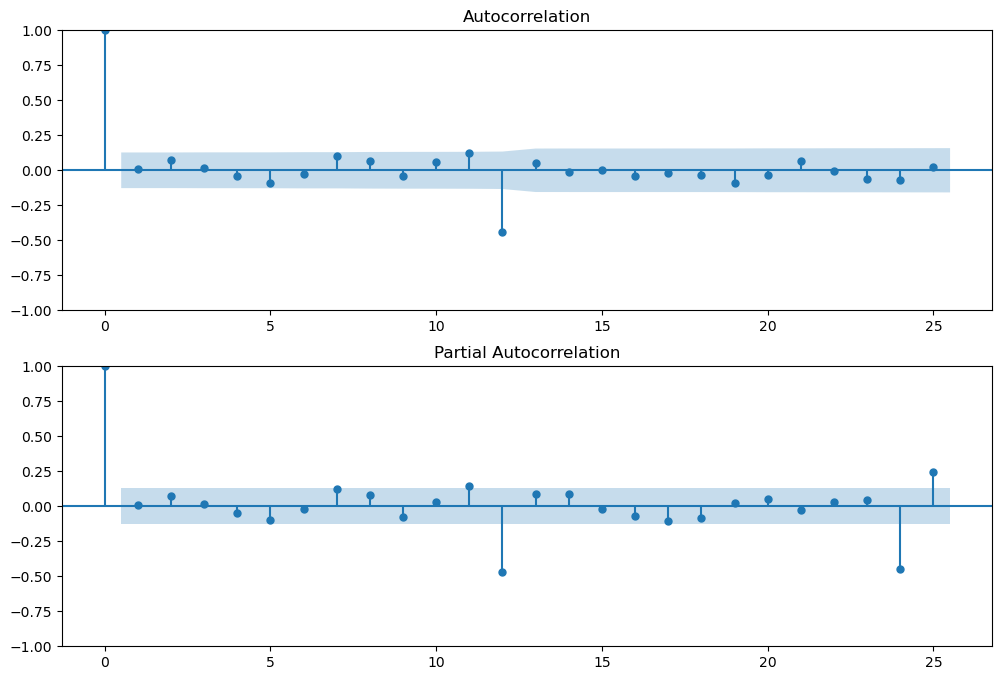

In [114]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma.resid, lags=25, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma.resid, lags=25, ax=ax2)

## SARIMA

### Determin (p,d,q),(P,D,Q)s

In [121]:
import itertools

p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Specify to use AIC for model selection
best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(df, order=param, seasonal_order=param_seasonal)
            model_fit = model.fit(disp=False)
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = model_fit
        except:
            continue

print(f'Best SARIMA model: {best_pdq}x{best_seasonal_pdq} with AIC: {best_aic}')


Best SARIMA model: (1, 1, 1)x(1, 0, 1, 12) with AIC: 247.86960287217354


In [122]:
model_2 = SARIMAX(df, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
sarima = model_2.fit(disp=False)
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Inflation Rate   No. Observations:                  297
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -118.935
Date:                            Tue, 21 Nov 2023   AIC                            247.870
Time:                                    22:37:38   BIC                            266.321
Sample:                                         0   HQIC                           255.257
                                            - 297                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9896      0.016     61.930      0.000       0.958       1.021
ma.L1         -0.8372      0.029   

In [123]:
# p-value for Ljung-Box test is really close to 0.05, may not be a good model

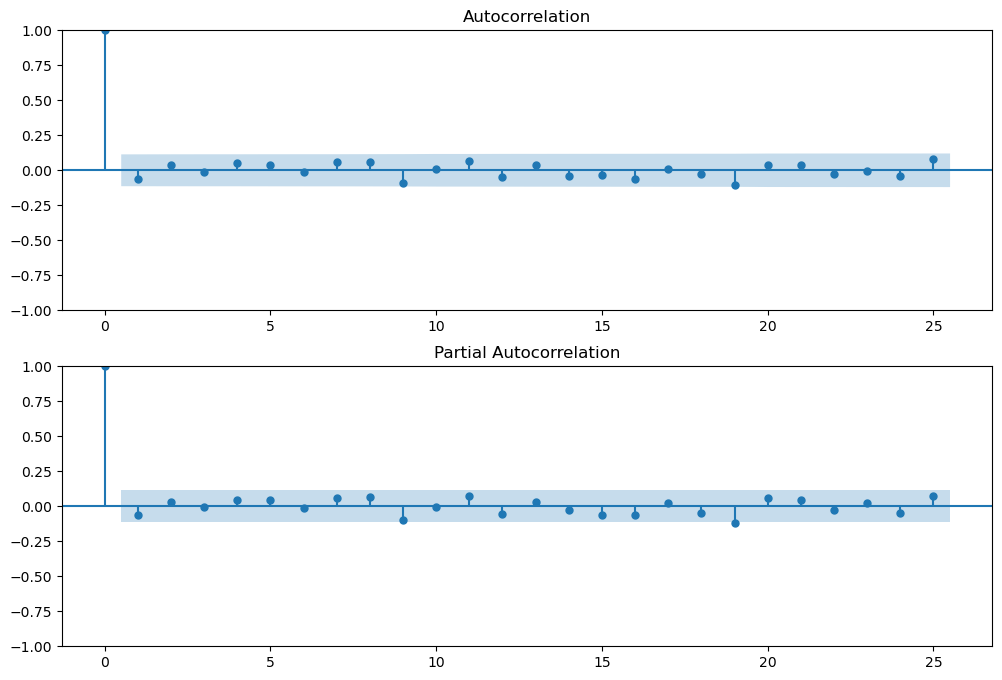

In [124]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima.resid, lags=25, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima.resid, lags=25, ax=ax2)

In [126]:
lb_test = sm.stats.acorr_ljungbox(sarima.resid, lags=10)
lb_test

,lb_stat,lb_pvalue
1,1.186369,0.276063
2,1.602063,0.448866
3,1.635412,0.651387
4,2.381194,0.666028
5,2.873331,0.719507
6,2.918885,0.818957
7,3.999511,0.779834
8,5.046883,0.752554
9,7.602861,0.574609
10,7.625947,0.665321


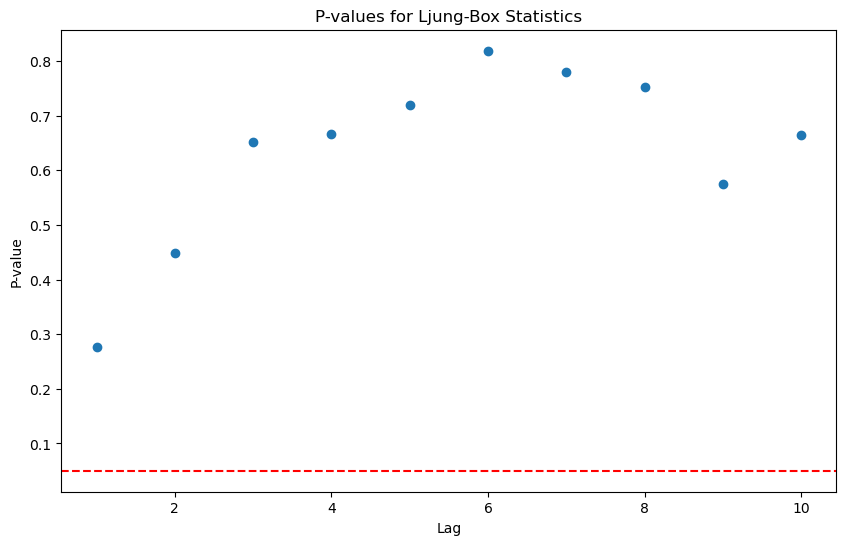

In [129]:
#lb_test = sm.stats.acorr_ljungbox(sarima.resid, lags=10)

# Extract the p-values
p_values = lb_test['lb_pvalue']

# Plot the p-values
plt.figure(figsize=(10,6))
plt.plot(p_values, 'o')
plt.axhline(y=0.05, linestyle='--', color='red')  
plt.title('P-values for Ljung-Box Statistics')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.show()

# 3. Predict

In [135]:
predictions=sarima.forecast(60)

In [136]:
mean_squared_error(test, predictions)

1.4753011797803441

In [138]:
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.215
